**Name:** \_\_\_\_\_Huanchen Wang\_\_\_\_\_

**EID:** \_\_\_\_\_huancwang2\_\_\_\_\_

# CS5489 - Tutorial 7
## Image Segmentation using Clustering

In this tutorial you will use clustering algorithms to generate a segmentation of an image.  An image segmentation is a separation of an image into regions belonging to distinct objects.
First we need to initialize Python.  Run the below cell.

In [5]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('jpg')
# jpg is better for images in this tutorial
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
import skimage.io
import skimage.color
import skimage.util
random.seed(100)

##  Loading Data and Pre-processing
Next we need to load the data.  Download `imgdb.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the image data.

In [7]:
filelist = glob.glob('imgdb/jpg/*.jpg')
gtpath   = 'imgdb/gtruth/'
if len(filelist) == 0:
    warn.error("Could not find imgdb directory!  " + 
               "Make sure you put it here: " + os.getcwd() )
else:
    imgdata = []
    gtdata  = []
    
    # load image data
    for f in filelist:
        # load image - byte [0 to 255]
        img = skimage.io.imread(f)
        
        (fdir1, fname)  = os.path.split(f)        

        # load GT segmentation (non-consecutive integers)
        gname = gtpath + fname[:-4] + "-gt.png"
        gtimg = skimage.io.imread(gname)
        
        # convert to consecutive integers
        cl = unique(gtimg)
        gtimg0 = gtimg.copy().astype(float64)
        for i in range(len(cl)):
            gtimg0[gtimg==cl[i]] = i
        
        imgdata.append(img)
        gtdata.append(gtimg0)
print(len(imgdata))

14


There are 14 images.  Each image also has a ground-truth segmentation that was created by a human annotation.  Here is an example:

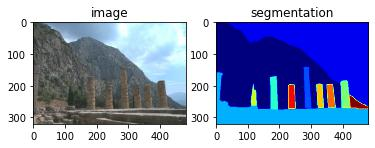

In [8]:
plt.subplot(1,2,1)
plt.imshow(imgdata[6], aspect='equal')
plt.title('image')
plt.subplot(1,2,2)
plt.imshow(gtdata[6], aspect='equal', cmap='jet')
plt.title('segmentation');

##  Clustering with Color Features
To segment an image, we will extract features from each pixel location.  Then, we cluster the extracted features into groups.  Pixel location that are clustered into the same group form a segment.

For the features, we will use the "Lab" colorspace, rather than the RGB colors.  Also, we will ignore the "L" feature, which is brightness, resulting in a 2-dimensional color feature space (a, b). Here are a few helper functions: 1) extract Lab features along a regular grid on the image; 2) convert cluster labels into a segmentation image; 3) color a segmentation image using colors from the original image.

In [9]:
def getfeatures(img, segm=None, stepsize=7, use_loc = False):
    """
    getfeatures - extract features from an image
     [X, Y, L] = getfeatures(img, stepsize)
     INPUT
     img      - the image   [type = np.ndarray or Image]
     segm     - the gt segmentation (optional)
     stepsize - window stepsize
     OUTPUT
      X   - the features: each row is a feature vector  [type = np.ndarray]
      Y   - the GT segment labels for each feature (if segm is provided)
      L   - dictionary containing location information of each feature
    """
    winsize = 7 # ensure it is an odd number
    if stepsize > winsize:
        raise Exception('stepsize larger than window size')
    # convert to LAB
    yimg = skimage.color.rgb2lab(img)

    offset = floor((winsize-1)/2)
    sy,sx, sc = img.shape

    if use_loc:
        Xdim = 4
    else:
        Xdim = 2
    
    # extract window patches with stepsize
    patches = skimage.util.view_as_windows(yimg, (winsize, winsize, 3), step=stepsize)    
    psize = patches.shape
    
    # get coordinates of windows
    rangex = arange(psize[1])*stepsize + offset
    rangey = arange(psize[0])*stepsize + offset

    X = zeros((psize[0] * psize[1], Xdim));
    
    if segm is None:
        Y = None
    else:
        Y = zeros((X.shape[0],))
    
    i = 0
    for x in range(psize[1]):
        for y in range(psize[0]):
            myu = mean(patches[y,x,0,:,:,1].flatten())
            myv = mean(patches[y,x,0,:,:,2].flatten())
            myy = int(rangey[y])
            myx = int(rangex[x])
            
            if use_loc:
                X[i,:] = [myu, myv, myx, myy]
            else:
                X[i,:] = [myu, myv]
                
            if Y is not None:
                Y[i] = segm[myy, myx]
                
            i = i + 1 
    
    L = {'rangex':rangex, 'rangey':rangey, 'offset':offset, 'sx':sx, 'sy':sy, \
         'stepsize':stepsize, 'winsize':winsize}
    return X, Y, L

def labels2seg(Y,L):
    """
    labels2segm - form a segmentation image using cluster labels
    segm = labels2segm(Y, L)
    Y - cluster labels for each location
    L - location dictionary from getfeatures
    segm - output segmentation image
    """
    segm = zeros((L['sy'], L['sx']))
    # <= offset if floor((winsize-1)/2)>= floor(stepsize/2) 
    rstep = int(floor(L['stepsize']/2.0)) 
    stepbox = range(-rstep, L['stepsize'] - rstep)
    rx = asarray(L['rangex'], dtype=int) + int(L['offset'])
    ry = asarray(L['rangey'], dtype=int) + int(L['offset'])
    Y_reshaped = Y.reshape((ry.size, rx.size),order='F')
    for i in stepbox:
        for j in stepbox:
            segm[ix_(ry + j, rx + i)] = Y_reshaped
    ## Now fil in the borders if they are missing
    minx = min(rx) + stepbox[0] - 1
    maxx = max(rx) + stepbox[-1] + 1
    miny = min(ry) + stepbox[0] - 1
    maxy = max(ry) + stepbox[-1] + 1

    if 0 <= minx:
        ## fill in left edge
        segm[:, 0:minx+1] = segm[:,minx+1].reshape((-1,1))
    if maxx < L['sx']:
        ## fill in right edge
        segm[:,maxx:] = segm[:,maxx-1].reshape((-1,1))
    if 0 < miny:
        ## fill in top edge
        segm[0:miny+1,:] = segm[miny+1,:].reshape((1,-1))
    if maxy < L['sy']:
        ## fill in bottom edge
        segm[maxy:,:] = segm[maxy-1,:].reshape((1,-1))
    return segm    

def colorsegms(segm, img):
    """
    colorsegm - color a segmentation based on the image
    csegm = colorsegm(segm, img)
    segm = the segmentation image  [type = np.ndarray]
    img = the original image    [type = np.ndarray (or Image)]
    csegm = the colored segmentation -- each segment is colored based on the 
            average pixel color within the segment.
    """
    img = asarray(img).copy()
    if segm.shape[0:2] != img.shape[0:2]:
        raise Exception('The shape of segmentation and image are not consistent') 
    rimg, gimg, bimg = img[:,:,0], img[:,:,1], img[:,:,2]
    for i in range(0, int(max(segm.flatten())) + 1):
        # assume label starts from 1
        ind = (segm == i)
        rimg[ind] = mean(rimg[ind].flatten())
        gimg[ind] = mean(gimg[ind].flatten())
        bimg[ind] = mean(bimg[ind].flatten())
    # handle outliers from DBSCAN
    ind = (segm == -1)
    rimg[ind] = 0
    gimg[ind] = 0
    bimg[ind] = 0
    return img

Next, we use the `getfeatures` function to extract features from an image.  `X` contains the feature vectors. `L` contains information about where each features was extracted, which is used later generate the segmentation.

(3060, 2)


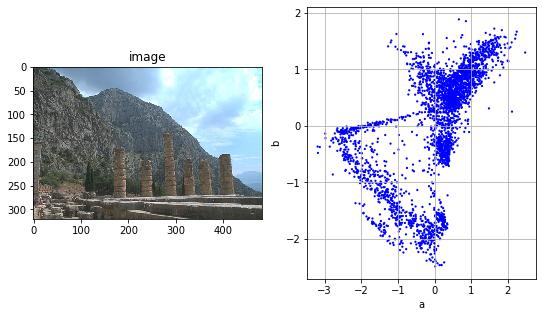

In [127]:
# image to use
img = imgdata[6]
gt  = gtdata[6]

# extract features, each row is a feature vector
Xo,Ytrue, L = getfeatures(img, gt)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()  
X = scaler.fit_transform(Xo)

# view the image
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(img, interpolation='nearest')
plt.title("image")

# view the features
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c='b', s=5, edgecolor='none')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Here is the segmented image, with the segment labels shown as colors.  The goal is to recoever these labels using clustering. 

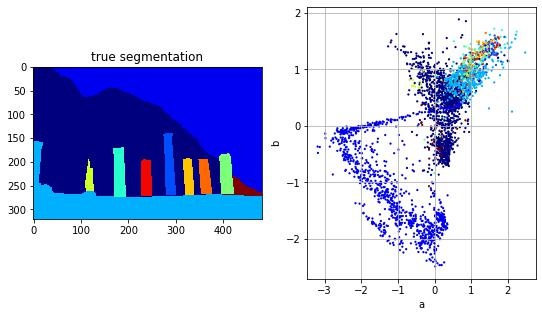

In [128]:
# view the image
plt.figure(figsize=(9,5))

plt.subplot(1,2,1)
plt.imshow(gt, interpolation='nearest', cmap='jet')
plt.title("true segmentation")

# view the features
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=Ytrue, s=5, edgecolor='none', cmap='jet')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Now use a clustering algorithm to group the data into 5 clusters.

In [ ]:
### INSERT YoUR CODE HERE

In [129]:
# Using the Expectation Maximization (EM) algorithm to cluster the data into 5 clusters
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full')
gmm.fit(X)
Y_pred = gmm.predict(X)


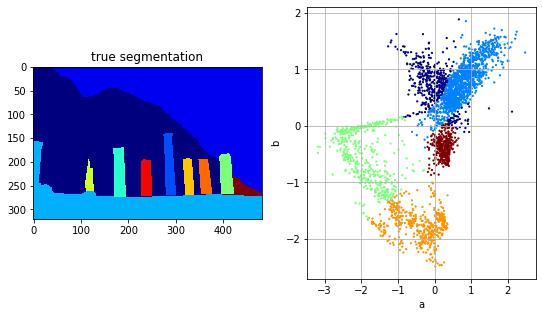

In [130]:
plt.figure(figsize=(9,5))

plt.subplot(1,2,1)
plt.imshow(gt, interpolation='nearest', cmap='jet')
plt.title("true segmentation")

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=Y_pred, s=5, edgecolor='none', cmap='jet')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Once you have the cluster labels (Y), use the below code to generate the segmentation image and view it.  You can also view the scatter plot with `showscatter`.

In [15]:
def showsegm(segm, img):
    "show a segmentation"
    
    # fill segmentation with colors from the image
    csegm = colorsegms(segm, img)
    
    # view the images, segmentation, and ground-truth
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(img, interpolation='nearest')
    plt.title('image')
    plt.subplot(1,3,2)
    plt.imshow(segm, interpolation='nearest', cmap='jet')
    plt.title('segmentation')
    plt.subplot(1,3,3)
    plt.imshow(gt, interpolation='nearest', cmap='jet')
    plt.title("ground truth")
    
    return segm

def showscatter(X,Y):
    "show a scatter plot of clusters"
    
    if X.shape[1] == 2:
        plt.figure()
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.grid(True)
        plt.xlabel('a')
        plt.ylabel('b')
    else:
        plt.figure(figsize=(12,3))

        plt.subplot(1,4,1)
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('a'); plt.ylabel('b'); plt.grid(True)

        plt.subplot(1,4,2)
        plt.scatter(X[:,2], X[:,3], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('x-pos'); plt.ylabel('y-pos'); plt.grid(True)

        plt.subplot(1,4,3)
        plt.scatter(X[:,2], X[:,0], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('x-pos'); plt.ylabel('a'); plt.grid(True)

        plt.subplot(1,4,4)
        plt.scatter(X[:,3], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('y-pos'); plt.ylabel('b'); plt.grid(True)
        
        plt.tight_layout()

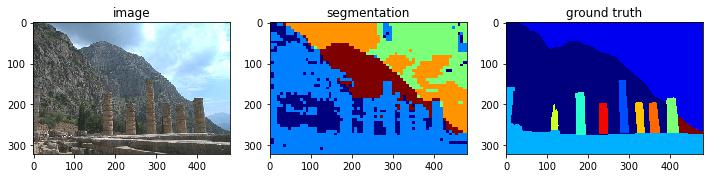

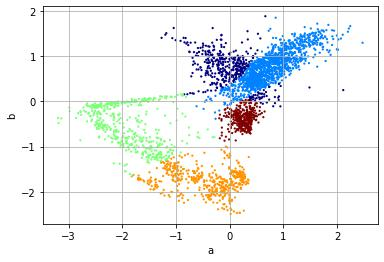

In [131]:
# convert cluster labels to a segmentation image
segm = labels2seg(Y_pred, L)

# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y_pred)

Next we evaluate the segmentation with the ground-truth provided by a human annotator.  We cannot just check that the cluster assignments for each pixel are the same, since the cluster indices can be permuted.  We will use the _Adjusted Rand Index_, which calculates how often a pair of pixels is assigned correctly to the same cluster or not.  Use the below code to calculate the ARI. Higher values are better, and the maximum value is 1. 

In [17]:
# calculate ARI
#ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
ari = metrics.adjusted_rand_score(Ytrue, Y_pred)
print("ARI =",ari)

ARI = 0.25499984840344225


Try different clustering algorithms and settings (K, bandwidth, etc) to get the best segmentation as measured by ARI. 

In [ ]:
### INSERT YOUR CODE HERE

### Try 4 different clustering algorithms, including:
1. K-means
2. EM
3. Mean-shift
4. Spectral clustering
### And try different setting for each algorithm

In [94]:
# K-means clustering
Ks = [5, 7, 10, 11, 12, 15]
max_ARI = 0
max_cls = []
ARIs = []
for K in Ks:
    kmeans = cluster.KMeans(n_clusters=K, random_state=0).fit(X)
    Y_pred = kmeans.predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y_pred)
    print('K =', K, 'ARI =', ari)
    ARIs.append(ari)
    if ari > max_ARI:
        max_ARI = ari
        max_cls.append(Y_pred)


K = 5 ARI = 0.4105924201620701
K = 7 ARI = 0.27416801896049764
K = 10 ARI = 0.2908725319964389
K = 11 ARI = 0.2521323743147244
K = 12 ARI = 0.2346345486894329
K = 15 ARI = 0.20359366913521074


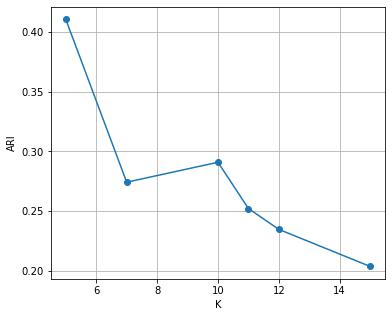

In [95]:
plt.figure(figsize=(6,5))
plt.plot(Ks, ARIs, 'o-')
plt.xlabel('K')
plt.ylabel('ARI')
plt.grid(True)
plt.show()

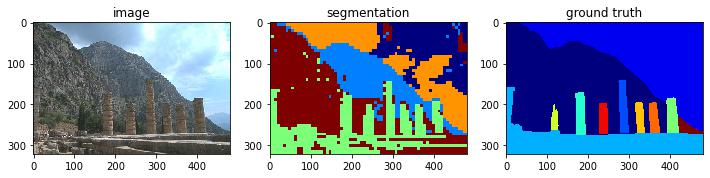

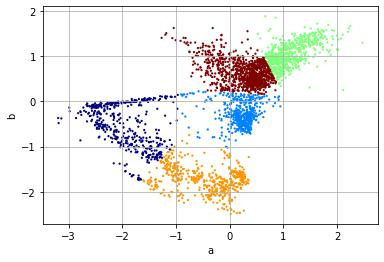

In [96]:
# best clustering in K-means:

segm = labels2seg(max_cls[-1], L)
showsegm(segm, img)
showscatter(X,max_cls[-1])

In [97]:
# EM clustering
Ks = [5, 7, 10, 11, 12, 15]
cov_types = ['spherical', 'diag', 'tied', 'full']
ARIs = []
max_ARI = 0
max_cls = []
for cov_type in cov_types:
    for K in Ks:
        gmm = mixture.GaussianMixture(n_components=K, covariance_type=cov_type, random_state=46)
        gmm.fit(X)
        Y_pred = gmm.predict(X)
        ari = metrics.adjusted_rand_score(Ytrue, Y_pred)
        print('K =', K, 'cov_type =', cov_type, 'ARI =', ari)
        ARIs.append(ari)    
        if ari > max_ARI:
            max_ARI = ari
            max_cls.append(Y_pred)

K = 5 cov_type = spherical ARI = 0.5066087042919495
K = 7 cov_type = spherical ARI = 0.27359359049219667
K = 10 cov_type = spherical ARI = 0.28671134505950197
K = 11 cov_type = spherical ARI = 0.2702606786490873
K = 12 cov_type = spherical ARI = 0.24838937453977425
K = 15 cov_type = spherical ARI = 0.21263015240027586
K = 5 cov_type = diag ARI = 0.5346707337343337
K = 7 cov_type = diag ARI = 0.27761963004550483
K = 10 cov_type = diag ARI = 0.2805193142085369
K = 11 cov_type = diag ARI = 0.2729262188753189
K = 12 cov_type = diag ARI = 0.2499982880103193
K = 15 cov_type = diag ARI = 0.21088596323538278
K = 5 cov_type = tied ARI = 0.5186542143155705
K = 7 cov_type = tied ARI = 0.27877274519298306
K = 10 cov_type = tied ARI = 0.3046832555711087
K = 11 cov_type = tied ARI = 0.30051104434651615
K = 12 cov_type = tied ARI = 0.25679534783166175
K = 15 cov_type = tied ARI = 0.2418523663932442
K = 5 cov_type = full ARI = 0.350152739285423
K = 7 cov_type = full ARI = 0.3074716256084979
K = 10 cov

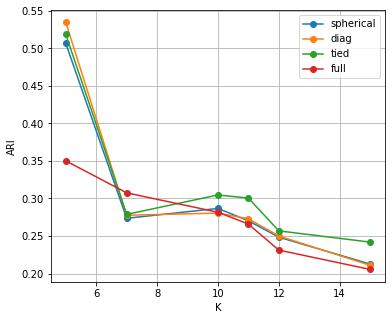

In [98]:
plt.figure(figsize=(6,5))
index = 0
for cov_type in cov_types:
    plt.plot(Ks, ARIs[index:index+len(Ks)], 'o-', label=cov_type)
    index += len(Ks)
plt.xlabel('K')
plt.ylabel('ARI')
plt.grid(True)
plt.legend()
plt.show()

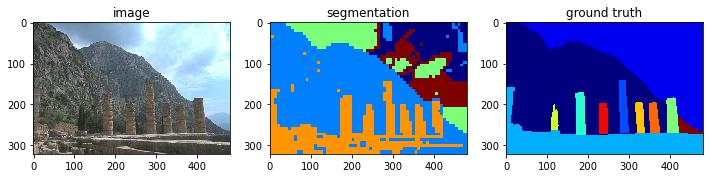

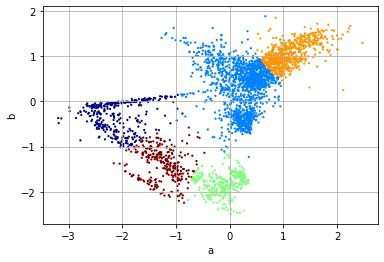

In [99]:
# best clustering in EM:

segm = labels2seg(max_cls[-1], L)
showsegm(segm, img)
showscatter(X,max_cls[-1])

In [103]:
# Mean-shift clustering
bandwidths = [0.3,0.4, 0.5, 0.6, 0.8, 0.9]
ARIs = []
max_ARI = 0
max_cls = []
for bandwidth in bandwidths:
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    Y_pred = ms.predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y_pred)
    print('bandwidth =', bandwidth, 'ARI =', ari)
    ARIs.append(ari)
    if ari > max_ARI:
        max_ARI = ari
        max_cls.append(Y_pred)

bandwidth = 0.3 ARI = 0.3092279013947139
bandwidth = 0.4 ARI = 0.2197101858974923
bandwidth = 0.5 ARI = 0.2299986729788752
bandwidth = 0.6 ARI = 0.3258543837575973
bandwidth = 0.8 ARI = 0.2998031285185163
bandwidth = 0.9 ARI = 0.3035749080403646


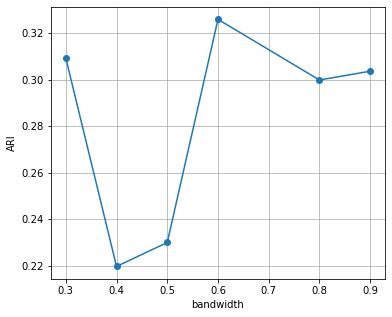

In [104]:
plt.figure(figsize=(6,5))
plt.plot(bandwidths, ARIs, 'o-')
plt.xlabel('bandwidth')
plt.ylabel('ARI')
plt.grid(True)
plt.show()

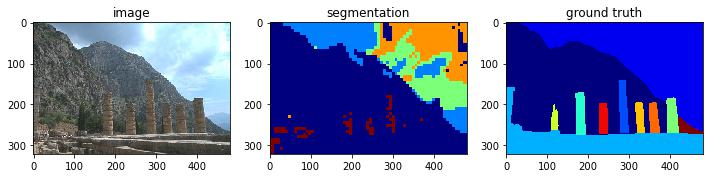

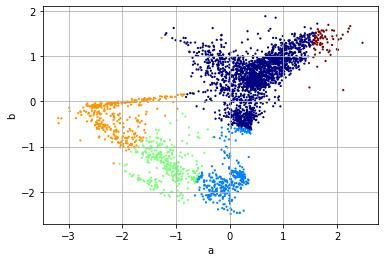

In [105]:
# best clustering in Mean-shift:

segm = labels2seg(max_cls[-1], L)
showsegm(segm, img)
showscatter(X,max_cls[-1])

In [106]:
# Spectral clustering
params = {'n_clusters': [5, 7, 10, 11, 12], 'gamma': [0.1, 0.3, 0.5, 0.7], 'affinity': ['rbf', 'nearest_neighbors']}
ARIs = []
max_ARI = 0
max_cls = []
for affinity in params['affinity']:
    for gamma in params['gamma']:
        for K in params['n_clusters']:
            sc = cluster.SpectralClustering(n_clusters=K, gamma=gamma, affinity=affinity)
            sc.fit(X)
            Y_pred = sc.labels_
            ari = metrics.adjusted_rand_score(Ytrue, Y_pred)
            print('K =', K, 'gamma =', gamma, 'affinity =', affinity, 'ARI =', ari)
            ARIs.append(ari)
            if ari > max_ARI:
                max_ARI = ari
                max_cls.append(Y_pred)

K = 5 gamma = 0.1 affinity = rbf ARI = 0.41157146077656476
K = 7 gamma = 0.1 affinity = rbf ARI = 0.2428216363022986
K = 10 gamma = 0.1 affinity = rbf ARI = 0.20036306773865284
K = 11 gamma = 0.1 affinity = rbf ARI = 0.2627975392452636
K = 12 gamma = 0.1 affinity = rbf ARI = 0.26063804840860605
K = 5 gamma = 0.3 affinity = rbf ARI = 0.4829950315233963
K = 7 gamma = 0.3 affinity = rbf ARI = 0.24409468546700228
K = 10 gamma = 0.3 affinity = rbf ARI = 0.21139957060205827
K = 11 gamma = 0.3 affinity = rbf ARI = 0.3242299887919732
K = 12 gamma = 0.3 affinity = rbf ARI = 0.22697000096927256
K = 5 gamma = 0.5 affinity = rbf ARI = 0.49638341851180845
K = 7 gamma = 0.5 affinity = rbf ARI = 0.24644516610597736
K = 10 gamma = 0.5 affinity = rbf ARI = 0.2092275801969665
K = 11 gamma = 0.5 affinity = rbf ARI = 0.20116686736988135
K = 12 gamma = 0.5 affinity = rbf ARI = 0.18748179731206824
K = 5 gamma = 0.7 affinity = rbf ARI = 0.5129791751440402
K = 7 gamma = 0.7 affinity = rbf ARI = 0.256959211181

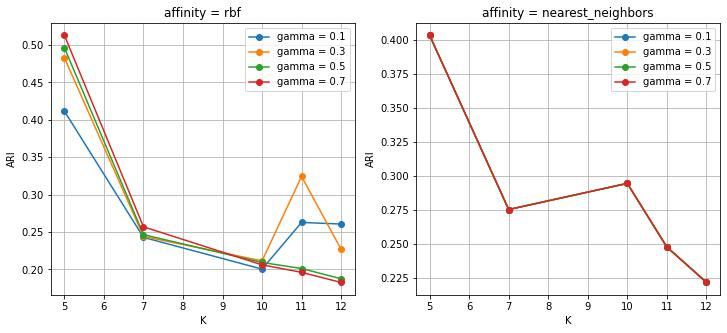

In [107]:
plt.figure(figsize=(12,5))
index_K1 = 0
index_K2 = len(params['n_clusters'])*len(params['gamma'])
for gamma in params['gamma']:
    plt.subplot(1, 2, 1)
    plt.plot(params['n_clusters'], ARIs[index_K1:index_K1+len(params['n_clusters'])], 'o-', label='gamma = ' + str(gamma))
    plt.title('affinity = rbf')
    plt.legend()
    plt.grid(True)
    plt.xlabel('K')
    plt.ylabel('ARI')
    plt.subplot(1, 2, 2)
    plt.plot(params['n_clusters'], ARIs[index_K2:index_K2+len(params['n_clusters'])], 'o-', label='gamma = ' + str(gamma))
    plt.title('affinity = nearest_neighbors')
    plt.legend()
    plt.grid(True)
    plt.xlabel('K')
    plt.ylabel('ARI')
    index_K1 += len(params['n_clusters'])
    index_K2 += len(params['n_clusters'])

plt.show()

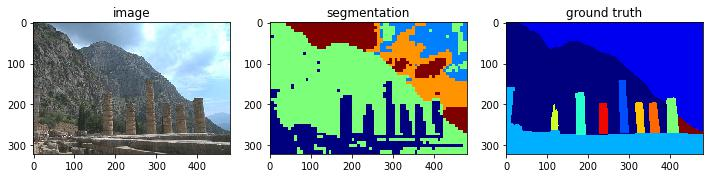

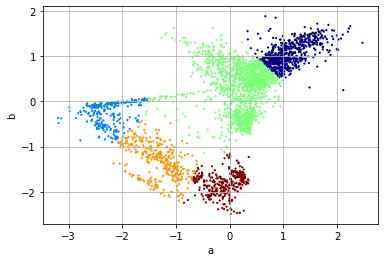

In [108]:
# best clustering in Spectral clustering:

segm = labels2seg(max_cls[-1], L)
showsegm(segm, img)
showscatter(X,max_cls[-1])


_Which algorithm performs the best?  Why?_
- **INSERT YOUR ANSWER HERE**

I think the Expectation Maximization clustering performs the best. 
Here are some reasons:
1. The ARI of EM is the highest among all the algorithms.
2. The segmentation result of the EM clustering is closer to the ground truth, in other words, it has higher or more make sense with in semantic dimension.
3. The segmentation results of the K-means have less cross region, which might mean the boundary between clusters are clearer and smoother.

To the EM clustering, it has advantages in the following aspects:
1. The EM algorithm is a probabilistic clustering algorithm, which means that it models the data as a set of probability distributions. This can be useful when the data is naturally probabilistic, or when there is uncertainty in the data. 
   
   By modeling the data probabilistically, the EM algorithm can capture the underlying structure of the data more accurately than other clustering algorithms.
2. The EM algorithm is less sensitive to noise in the data than K-means and other clustering algorithms, because it models the data probabilistically and can identify and remove outliers.
3. The EM algorithm can identify overlapping clusters, which can be useful in cases where clusters may overlap, or when there is ambiguity between clusters.


## Color and Position Features
You may notice that the segmentation is not spatially smooth -- that is, there are some "loner" pixels that are not the same cluster as the surrounding pixels.  This is because we are only clustering color.  One way to fix this is to include the (x,y) coordinate of the pixel as part of the feature vector.  This way, clusters will have pixels that are spatially close together.

The below code extracts a 4-dimensional feature vector, where the first 2 features are the color channels and the last 2 features are the position.

In [109]:
# extract features with location
Xo,Ytrue,L = getfeatures(img, gt, use_loc=True)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()  
X = scaler.fit_transform(Xo)

# rescale position features
# larger values emphasize clustering by position more
X[:,2:4] *= 0.5

(3060, 4)


Here are plots of the 4 features.

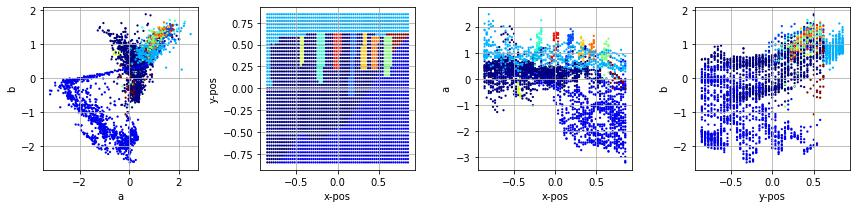

In [110]:
showscatter(X, Ytrue)

Run clustering algorithms on the 4-dimensional data.  Try different algorithms and parameters to get the best ARI.

In [ ]:
### INSERT YOUR CODE HERE

In [117]:
# K-means clustering
Ks = [5, 7, 10, 11, 12, 15]
ARIs = []
max_ARI = 0
max_cls = []
for K in Ks:
    kmeans = cluster.KMeans(n_clusters=K, random_state=0)
    kmeans.fit(X)
    Y_pred = kmeans.predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y_pred)
    print('K =', K, 'ARI =', ari)
    ARIs.append(ari)
    if ari > max_ARI:
        max_ARI = ari
        max_cls.append(Y_pred)

K = 5 ARI = 0.45290193467416134
K = 7 ARI = 0.32744235667358035
K = 10 ARI = 0.27544306924948936
K = 11 ARI = 0.2864885115764274
K = 12 ARI = 0.2748399320778071
K = 15 ARI = 0.2147969280777567


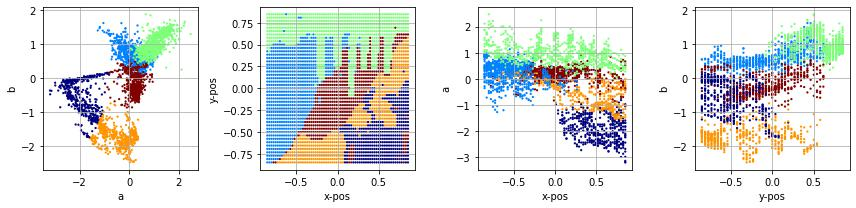

In [118]:
showscatter(X,max_cls[-1])

In [119]:
# Em clustering
Ks = [5, 7, 10, 11, 12, 15]
cov_types = ['spherical', 'diag', 'tied', 'full']
ARIs = []
max_ARI = 0
max_cls = []
for cov_type in cov_types:
    for K in Ks:
        gmm = mixture.GaussianMixture(n_components=K, covariance_type=cov_type, random_state=46)
        gmm.fit(X)
        Y_pred = gmm.predict(X)
        ari = metrics.adjusted_rand_score(Ytrue, Y_pred)
        print('K =', K, 'cov_type =', cov_type, 'ARI =', ari)
        ARIs.append(ari)    
        if ari > max_ARI:
            max_ARI = ari
            max_cls.append(Y_pred)

K = 5 cov_type = spherical ARI = 0.4660673877975318
K = 7 cov_type = spherical ARI = 0.3222655370254377
K = 10 cov_type = spherical ARI = 0.26275687127018926
K = 11 cov_type = spherical ARI = 0.27299314204874614
K = 12 cov_type = spherical ARI = 0.27548518845150977
K = 15 cov_type = spherical ARI = 0.2322568604857722
K = 5 cov_type = diag ARI = 0.32492654731859827
K = 7 cov_type = diag ARI = 0.3302774605644275
K = 10 cov_type = diag ARI = 0.29480422870293793
K = 11 cov_type = diag ARI = 0.2833088084592772
K = 12 cov_type = diag ARI = 0.26986930805694115
K = 15 cov_type = diag ARI = 0.23886627669324983
K = 5 cov_type = tied ARI = 0.45954805706296953
K = 7 cov_type = tied ARI = 0.295328844298912
K = 10 cov_type = tied ARI = 0.2801997201206512
K = 11 cov_type = tied ARI = 0.30158561938835
K = 12 cov_type = tied ARI = 0.2961212723477854
K = 15 cov_type = tied ARI = 0.2438799065181666
K = 5 cov_type = full ARI = 0.45447076281713916
K = 7 cov_type = full ARI = 0.36274326362443027
K = 10 cov_

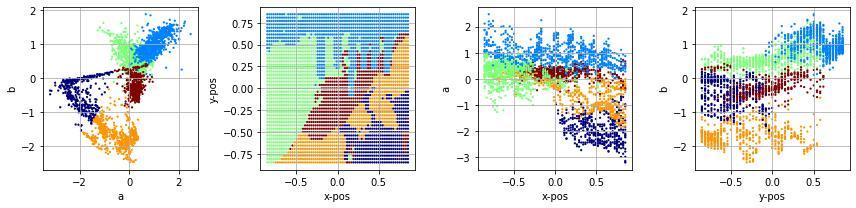

In [120]:
showscatter(X,max_cls[-1])

In [115]:
# Mean-shift clustering
bandwidths = [0.3, 0.4, 0.5, 0.6, 0.8, 0.9]
ARIs = []
max_ARI = 0
max_cls = []
for bandwidth in bandwidths:
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=False)
    ms.fit(X)
    Y_pred = ms.predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y_pred)
    print('bandwidth =', bandwidth, 'ARI =', ari)
    ARIs.append(ari)
    if ari > max_ARI:
        max_ARI = ari
        max_cls.append(Y_pred)

bandwidth = 0.3 ARI = 0.11577287020236962
bandwidth = 0.4 ARI = 0.21008327461636564
bandwidth = 0.5 ARI = 0.2927018231231433
bandwidth = 0.6 ARI = 0.31475325106335195
bandwidth = 0.8 ARI = 0.4067184112944789
bandwidth = 0.9 ARI = 0.31775359794193486


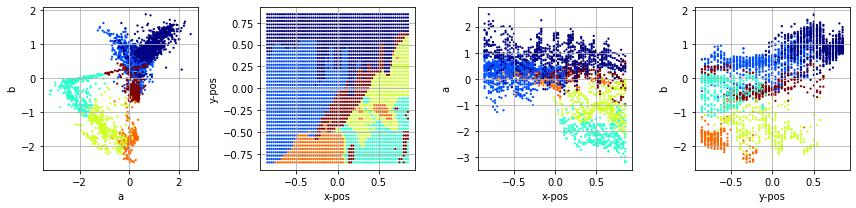

In [116]:
showscatter(X,max_cls[-1])

In [121]:
# Spectral clustering
params = {'n_clusters': [5, 7, 10, 11, 12], 'gamma': [0.1, 0.3, 0.5, 0.7], 'affinity': ['rbf', 'nearest_neighbors']}
ARIs = []
max_ARI = 0
max_cls = []
for affinity in params['affinity']:
    for gamma in params['gamma']:
        for K in params['n_clusters']:
            sc = cluster.SpectralClustering(n_clusters=K, gamma=gamma, affinity=affinity)
            sc.fit(X)
            Y_pred = sc.labels_
            ari = metrics.adjusted_rand_score(Ytrue, Y_pred)
            print('K =', K, 'gamma =', gamma, 'affinity =', affinity, 'ARI =', ari)
            ARIs.append(ari)
            if ari > max_ARI:
                max_ARI = ari
                max_cls.append(Y_pred)

K = 5 gamma = 0.1 affinity = rbf ARI = 0.4570840405731519
K = 7 gamma = 0.1 affinity = rbf ARI = 0.35047001439316183
K = 10 gamma = 0.1 affinity = rbf ARI = 0.30069606906543245
K = 11 gamma = 0.1 affinity = rbf ARI = 0.28404423520236605
K = 12 gamma = 0.1 affinity = rbf ARI = 0.2943495917230332
K = 5 gamma = 0.3 affinity = rbf ARI = 0.5834564234907137
K = 7 gamma = 0.3 affinity = rbf ARI = 0.35179164803022933
K = 10 gamma = 0.3 affinity = rbf ARI = 0.2977844542435365
K = 11 gamma = 0.3 affinity = rbf ARI = 0.2604747904644319
K = 12 gamma = 0.3 affinity = rbf ARI = 0.26818502858304344
K = 5 gamma = 0.5 affinity = rbf ARI = 0.5908003644171127
K = 7 gamma = 0.5 affinity = rbf ARI = 0.3572485601878859
K = 10 gamma = 0.5 affinity = rbf ARI = 0.29803782487817293
K = 11 gamma = 0.5 affinity = rbf ARI = 0.24980498551265834
K = 12 gamma = 0.5 affinity = rbf ARI = 0.2780234563891489
K = 5 gamma = 0.7 affinity = rbf ARI = 0.5940462097061726
K = 7 gamma = 0.7 affinity = rbf ARI = 0.361574995797790

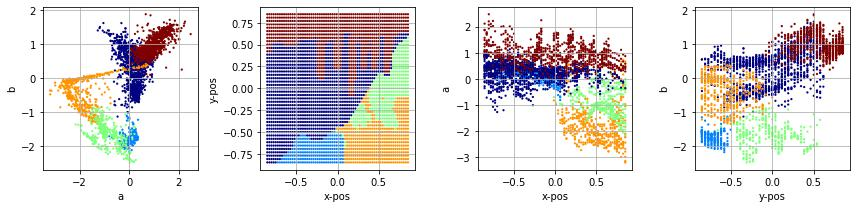

In [122]:
showscatter(X,max_cls[-1])

array([[0., 0., 0., ..., 3., 3., 3.],
       [0., 0., 0., ..., 3., 3., 3.],
       [0., 0., 0., ..., 3., 3., 3.],
       ...,
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.]])

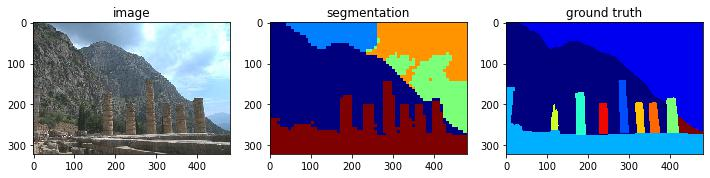

In [123]:
segm = labels2seg(max_cls[-1], L)
showsegm(segm, img)

_Which method performs the best?  Why?_
- **INSERT YOUR ANSWER HERE**

The Spectral clustering performs the best. Here are some reasons:
1. The ARI of Spectral clustering is the highest among all the algorithms.
2. It segmented the main object in the image better than the other algorithms, including 5 towers, mountain, and sky.

To the advantage of Spectral clustering that cause it performs the best, it has advantages in the following aspects:
1. Spectral clustering can handle non-linearly separable data and can find clusters of arbitrary shapes, whereas K-means, EM, and mean shift algorithms are based on distance metrics and assume that clusters are spherical and isotropic.
2. Spectral clustering uses affinity information between data points, which captures the similarity or dissimilarity between them. This affinity information can be derived from various sources, such as distance metrics, kernel functions, or graph structures. By incorporating this affinity information, spectral clustering can capture complex relationships between data points and produce more meaningful clusters.
3. Spectral clustering is less sensitive to noise in the data than K-means, EM, and mean shift algorithms, which can be important when dealing with real-world datasets that often contain noisy data

_Does including the position features improve the segmentation results?_
- **INSERT YOUR ANSWER HERE**

I think YES. Because:
1. The best ARI result of each algorithm has improved, especially the Spectral clustering.
2. The cluster semantic is more clear and smooth, which means the boundary between clusters are clearer and smoother rather than pervious: some clusters have a small part embed in other cluster.

To the reasons:
I think positional features can capture the spatial relationships between data points, which is often an important aspect of the underlying structure of the data.

By incorporating positional features into the clustering algorithm, the algorithm can take into account the spatial relationships between data points and produce more meaningful clusters. 

Positional features can help to reduce the impact of irrelevant or noisy features on the clustering results, by providing additional information that is relevant to the clustering problem. This can be particularly helpful when dealing with high-dimensional data, where many features may be irrelevant or noisy, and can lead to overfitting or poor clustering performance.